# Introduction to Yelp Review Sentiment Classification

In this project, we will build a classifier that can predict a user's rating of a given restaurant from their review. In doing so, we will explore the broader topic of sentiment analysis, that is, being able to quantify an individual's opinion about a particular topic merely from the words they use. Nowadays, sentiment analysis is used widely by companies in order to better understand their user's preferences and tastes.




![Example of a Yelp review](https://wordstream-files-prod.s3.amazonaws.com/s3fs-public/styles/simple_image/public/images/yelp-reviews-filtered.png)

In [4]:
#@title Import our libraries (this may take a minute or two)
import pandas as pd   # Great for tables (google spreadsheets, microsoft excel, csv). 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
import spacy
import wordcloud
import os # Good for navigating your computer's files 
import sys

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from spacy.lang.en.stop_words import STOP_WORDS
nltk.download('wordnet')
nltk.download('punkt')

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
!python -m spacy download en_core_web_md
import en_core_web_md



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
     |████████████████████████████████| 96.4MB 1.2MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-cp36-none-any.whl size=98051305 sha256=de10b0ae917a3781ea5f049564d29308430a2c4a6f1ec2fecb45c11dc4590330
  Stored in directory: /tmp/pip-ephem-wheel-cache-gpa1f2lo/wheels/df/94/ad/f5cf59224cea6b5686ac4fd1ad19c8a07bc026e13c36502d81
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [0]:
#@title Import our data

import gdown
gdown.download('https://drive.google.com/uc?id=1u0tnEF2Q1a7H_gUEH-ZB3ATx02w8dF4p', 'yelp_final.csv', True)
data_file  = 'yelp_final.csv'


## Data Exploration

First we read in the file containing the reviews and take a look at the data available to us.

In [0]:
# read our data in using 'pd.read_csv('file')'
yelp = pd.read_csv(data_file)

In [7]:
#@title Show data
yelp.head()

,business_id,stars,text,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,5,My wife took me here on my birthday for breakf...,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,5,I have no idea why some people give bad review...,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,_1QQZuf4zZOyFCvXc0o6Vg,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",uZetl9T0NcROGOyFfughhg,1,2,0
3,6ozycU1RpktNG2-1BroVtw,5,General Manager Scott Petello is a good egg!!!...,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0
4,zp713qNhx8d9KCJJnrw1xA,5,Drop what you're doing and drive here. After I...,wFweIWhv2fREZV_dYkz_1g,7,7,4


We have access to 7 columns of data. For our purposes the business_id and user_id information are not important. Also as you can see the data in these columns do not really correspond to business names or user names. They are random strings, generated by a process called hashing to anonymize the users and businesses.

What is *hashing*? We do not need to go in depth about this as it is a concept from computer science unrelated to machine learning. It is a way of *encrypting* data using some predefined function, that maps any kind of data to a random string of a defined length. You can read more about it [here](https://medium.com/tech-tales/what-is-hashing-6edba0ebfa67). 




In [0]:
#@title **Run to remove unnecessary columns** { display-mode: "form" }
yelp.drop(labels=['business_id','user_id'],inplace=True,axis=1)

The text column is the one we are primarily focused with. Let's take a look at a few of these reviews to better understand our problem.

In [9]:
#@title Check the text in differently rated reviews
num_stars = 1 #@param {type:"integer"}

for t in yelp[yelp['stars'] == num_stars]['text'].head(20).values:
    print (t) 

U can go there n check the car out. If u wanna buy 1 there? That's wrong move! If u even want a car service from there? U made a biggest mistake of ur life!! I had 1 time asked my girlfriend to take my car there for an oil service, guess what? They ripped my girlfriend off by lying how bad my car is now. If without fixing the problem. Might bring some serious accident. Then she did what they said. 4 brand new tires, timing belt, 4 new brake pads. U know why's the worst? All of those above I had just changed 2 months before!!! What a trashy dealer is that? People, better off go somewhere!
Disgusting!  Had a Groupon so my daughter and I tried it out.  Very outdated and gaudy 80's style interior made me feel like I was in an episode of Sopranos.  The food itself was pretty bad.  We ordered pretty simple dishes but they just had no flavor at all!  After trying it out I'm positive all the good reviews on here are employees or owners creating them.
I've eaten here many times, but none as bad

We can start to see that there are certain quantitative differences between highly rated reviews and poorly rated reviews. Certain words, for example, 'delightful', 'impressive', 'amazing', might be more associated with 4 or 5 star reviews. However one might be able to see that these words might also be present in a 2 star review. For example: "The seating and ambience were impressive, but the food served to us was not". 


### **Exercise 1**

Can you think of any combinations of words, or rules, that would indicate how many stars a given review corresponds to? Note them down below:




In [0]:
#@title Rules
rule_1 = "old, not fresh" #@param {type:"string"}
rule_2 = "bad service, bad food" #@param {type:"string"}
rule_3 = "not worth" #@param {type:"string"}

It is not really the presence of individual words that gives us an indication of the stars given to a review, but more  the *relative occurrence* of these words in each review that might give us an indication of a user's rating. If this does not make sense immediately, do not worry, we will come back to this concept later. 


#### Word Clouds

Another way to take a look at the most prominent words in any given star rating is through the use of word clouds. 

Edit the value in the cell below to see the word cloud for each star rating.

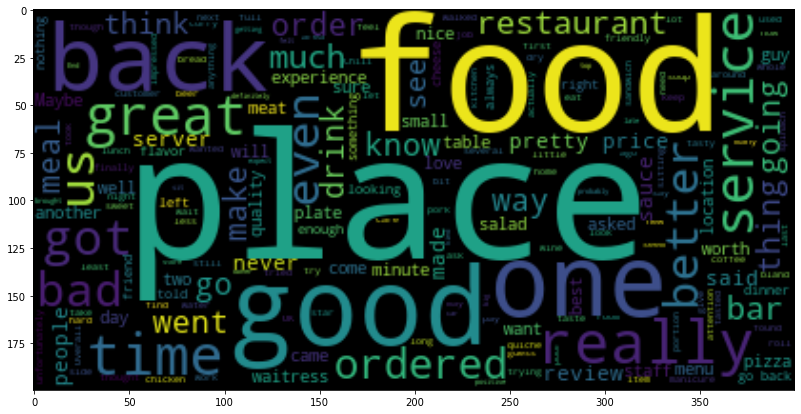

In [11]:
#@title Word cloud for differently rated reviews
num_stars =  2#@param {type:"integer"}
this_star_text = ''
for t in yelp[yelp['stars'] == num_stars]['text'].values: # form field cell
    this_star_text += t + ' '
    
wordcloud = WordCloud()    
wordcloud.generate_from_text(this_star_text)
plt.figure(figsize=(14,7))
plt.imshow(wordcloud, interpolation='bilinear')

**What are the differences between the reviews that have 1, 2, 3, 4, and 5 stars?**

*As* we can see, in this case, the word cloud does not give us a great deal of distinguishing information between reviews that have 1, 2, 3, 4, or 5 stars. All these reviews seem to prominently feature words such as 'place', 'food', 'service' and 'table'. Human intuition will only get us so far. 

Before we go any further, we will need to clean up our text.

## Text Preprocessing

#### Tokenization

First of all, we would like to convert each review from a single string into a list of words (this is a process known as tokenizaton). All NLP algorithms require a list of words as arguments and not actual sentences. Enter some example text into the cell below to see the tokenized version.

In [12]:
#@title Basic tokenization example
example_text = "All the people I spoke to were super nice and very welcoming." #@param {type:"string"}
tokens = word_tokenize(example_text)
tokens

['All',
 'the',
 'people',
 'I',
 'spoke',
 'to',
 'were',
 'super',
 'nice',
 'and',
 'very',
 'welcoming',
 '.']

#### Stopwords

We can see that certain particular words might be associated with 4 or 5 star reviews, and some words would be associated with 1 or 2 star reviews. However, at the same time, there are some words that do not really possess any relevant information for our current problem. In the field of NLP there is a concept of words that are "stopwords" - words that exist to provide grammatical structure, but do not convey information about the particular subject. Edit the cell below to see if a given word is a stop word.

In [13]:
#@title Check if a word is a stop word
example_word = "and" #@param {type:'string'}
if example_word.lower() in STOP_WORDS:
  print (example_word + " is a stop word.")
else:
  print (example_word + " is NOT a stop word.")
print(STOP_WORDS)

and is a stop word.
{'itself', 'formerly', 'from', 'though', 'up', 'around', 'why', 'have', '’m', '’re', 'much', 'my', 'name', 'might', 'ca', 'quite', 'own', 'am', 'fifty', "'d", 'whereby', 'done', 'nowhere', 'together', 'became', 'elsewhere', 'can', "'m", 'whose', 'being', 'give', 'meanwhile', 'until', "'s", '‘d', 'doing', 'onto', 'another', 'ever', 'whence', 'him', 'enough', 'often', 'please', "'re", 'on', 'per', 'but', 'put', 'with', '’ll', 'down', 'somewhere', 'which', 'yet', 'five', 'yours', "'ve", 'would', 'almost', 'here', 'thence', 'thereby', 'somehow', 'former', 'across', 'without', 'a', 'afterwards', 'in', 'that', 'all', 'do', 'everywhere', 'for', 'out', 'too', 'whether', 'n‘t', 'namely', 'several', 'eleven', 'so', 'six', 'their', 'he', 'could', 'regarding', 'sometimes', "n't", 'less', 'n’t', 'hundred', 'whoever', 'otherwise', 'herself', 'at', 'i', 'part', 'call', 'only', 'behind', 'nothing', 'because', 'there', 're', '‘re', 'most', 'already', 'me', 'whither', 'although', 'be

We would like to remove these stopwords from the user reviews.

Tokenization and removal of stop words are universal to nearly every NLP application. In some cases, additional cleaning may be required (for example, removal of proper nouns, removal of digits) but we can build a text preprocessing function with these "base" cleaning steps.

Putting all these together, we can come up with a text cleaning function that we can apply to all of our reviews.

Apply the text cleaning function on an example text to see if it works properly. 

# Intro to Spacy


Now a library we are going to use is Spacy.

Spacy, like the other Python libraries, gives us a lot of useful functions that we can directly use.

Unlike the other libraries, spacy does a lot more. It gives us insights into the English Language (actually, you can use many other languages here). The way it does is it downloads a set of information about the English Language and lets you use it.

`
nlp = spacy.load('en_core_web_sm')
`

Now when you call any sentence with this nlp object you will get quite a few helper functions that are really useful for a lot of tasks.

Lets explore some of the things that Spacy provides.


In [14]:
nlp = en_core_web_md.load()
doc = nlp(u"We are running out of time! Are we though?")
doc


We are running out of time! Are we though?

The doc object has a lot of nice properties. For instance you can get the text of each of the words and the length of each of the words.

In [0]:
doc = nlp(u"We are running out of time! Are we though?")
token = doc[0] # Get the first word in the text.
assert token.text == u"We" # Check that the token text is 'We'.
assert len(token) == 2 # Check that the length of the token is 2.

It has some word vectors that we can use. Though note that it doesn't have all the words. Let's import a new dataset of word (this may take a minute or so):

We can get the word embedding of a particular word in our document as follows:

In [16]:
doc = nlp(u"I like apples")
apples = doc[2]

print(apples.vector.shape) # Each word is being represented by 300 dimensional vector embedding

(300,)


The word 'Apple' is represented by a 300 dimensional vector embedding


### Fun things you can do with word vectors

### Exercise 2

You can get the similarity of two words via the following method:


```
doc = nlp(u"keyboard and mouse")
word1 = doc[0]
word2 = doc[2]
word1.similarity(word2)
```

**Use the above methodology to find two words with a similarity greater than 0.77 and two words with similarity less than 0.15. Share both of your word pairings with the class.**


In [17]:
### YOUR CODE HERE
w1 = nlp("apple")
w2 = nlp("plane")
w1.similarity(w2)
### END CODE

0.1494722213045396

In [18]:
w3 = nlp("steak")
w4 = nlp("sirloin")
w3.similarity(w4)

0.9999999921862055

As we saw before, the language in 4 star reviews is quite similar to the language in 5 star reviews. So the text in those reviews might not be very useful and we can drop those rows from our data.

Although the text in the 3 star reviews is not very similar to the 1 or 2 star reviews, it is quite different from the language used in the 5 star reviews. So we could actually group those reviews together with the 1 and 2 star reviews.

In order to reduce our problem to a **binary classification** problem, we will:

 - remove all 4 star reviews
 - label 5 star reviews as 'good'
 - label 1, 2, 3 star reviews as 'bad'

Run the cell below to get rid of 4 star reviews.

In [19]:
yelp = yelp[yelp.stars != 4]
yelp.head()

,stars,text,cool,useful,funny
0,5,My wife took me here on my birthday for breakf...,2,5,0
1,5,I have no idea why some people give bad review...,0,0,0
2,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",1,2,0
3,5,General Manager Scott Petello is a good egg!!!...,0,0,0
4,5,Drop what you're doing and drive here. After I...,7,7,4


### Exercise 3

Complete the second line of code in the cell below, and run it to re-categorize our reviews. 

In [0]:
def is_good_review(stars):
    if stars == 5:  ### TODO: FILL IN THE IF STATEMENT HERE ###:
        return True
    else:
        return False

# Change the stars field to either be 'good' or 'bad'.
yelp['is_good_review'] = yelp['stars'].apply(is_good_review)

## One-Hot Vectors

How do we convert our text to numbers in a structured way that we can feed into a machine learning algorithm? One way to do it is to use a concept called "one-hot encoding". We can see this concept with the following example. Suppose we have a sentence "great tacos at this restaurant". Its one-hot encoding would be.

In [21]:
#@title Run this to see the one-hot encoding of 'great tacos at this restaurant'
print('{:^5}|{:^5}|{:^4}|{:^4}|{:^10}'.format('great', 'tacos', 'at','this','restaurant'))
print('--------------------------------------------')
print('{:^5}|{:^5}|{:^4}|{:^4}|{:^10}'.format('1', '0', '0','0','0'))
print('{:^5}|{:^5}|{:^4}|{:^4}|{:^10}'.format('0', '1', '0','0','0'))
print('{:^5}|{:^5}|{:^4}|{:^4}|{:^10}'.format('0', '0', '1','0','0'))
print('{:^5}|{:^5}|{:^4}|{:^4}|{:^10}'.format('0', '0', '0','1','0'))
print('{:^5}|{:^5}|{:^4}|{:^4}|{:^10}'.format('0', '0', '0','0','1'))

great|tacos| at |this|restaurant
--------------------------------------------
  1  |  0  | 0  | 0  |    0     
  0  |  1  | 0  | 0  |    0     
  0  |  0  | 1  | 0  |    0     
  0  |  0  | 0  | 1  |    0     
  0  |  0  | 0  | 0  |    1     


###Exercise: One Hot Encoding - Sentences

Let's say you just have two reviews(vocabulary) as following:

1. I loved the restaurant
2. I hate the food 

The vocabulary would consist of unique words across both the reviews. Now create one-hot encoded vector for reviews above.

## Bag of Words

Building upon the concept of one-hot encoding is the **bag of words** model. If one-hot encoding is a way to represent individual words as vectors, then you can think of bag of words as a way to represent sentences (or larger pieces of text) as the **sum** of the one-hot encoding vectors of each of the words. Let's explain with an example. 

Suppose we want to represent the review: 
**"The food was great. The ambience was also great."** as a bag of words.

First we define our vocabulary. This is *each unique word* in the review. So our vocabulary is **[the, food, was, great, ambience, also]**.

What are our one hot encodings? 

the = (1,0,0,0,0,0)

food = (0,1,0,0,0,0)

was = (0,0,1,0,0,0)

great = (0,0,0,1,0,0)

ambience = (0,0,0,0,1,0)

also = (0,0,0,0,0,1).

So far, so simple. Now how do we represent the review we mentioned above as a bag of words? We know we only have 6 words in our vocabulary, so our bag of words vector will also only be 6 elements long. To construct it, we can start off with a (0,0,0,0,0,0) vector, and then pass through each word in the review. For each word we encounter, we simply add its one hot encoding to our vector! So for our review, the bag of words representation will be

**(2,1,2,2,1,1)**

## Creating our Bag of Words

Back to our data. We want to select the features for our model and the output classes from our data. What are the features? We are only using the review text to make predictions for our model. And the output classes are the 'good' and 'bad' review classes we created just above. 

By convention, we represent our entire set of features as X, and our target output as y. Running the cell below will create the relevant X and y for our problem.

In [0]:
X = yelp['text']
y = yelp['is_good_review']

In [23]:
X.shape, y.shape

((646,), (646,))

Running the cell below will create an object we can use to *transform* each piece of raw text into a bag of words vector.
CountVectorizer is a useful class we can call from scikit-learn that will help us create this object. It even has a helpful parameter that we can set to our tokenize function to preprocess the raw text.

In [0]:
#@title Initialize the text cleaning function { display-mode: "form" }
def tokenize(text):
    clean_tokens = []
    for token in nlp(text):
        if (not token.is_stop) & (token.lemma_ != '-PRON-') & (not token.is_punct): # -PRON- is a special all inclusive "lemma" spaCy uses for any pronoun, we want to exclude these 
            clean_tokens.append(token.lemma_)
    return clean_tokens

In [0]:
bow_transformer = CountVectorizer(analyzer=tokenize, max_features=800).fit(X)

We can see our entire vocabulary by running the cell below! You will also notice an index associated with each word - this is the position of each word in the vocabulary.

In [26]:
bow_transformer.vocabulary_

{'\n': 0,
 '\n\n': 1,
 ' ': 2,
 ' \n': 3,
 ' \n\n': 4,
 '  ': 5,
 '$': 6,
 '+': 7,
 '1': 8,
 '1/2': 9,
 '10': 10,
 '12': 11,
 '15': 12,
 '2': 13,
 '20': 14,
 '25': 15,
 '3': 16,
 '30': 17,
 '4': 18,
 '5': 19,
 '6': 20,
 '7': 21,
 '8': 22,
 '9': 23,
 '=': 24,
 'ASU': 25,
 'AZ': 26,
 'Arizona': 27,
 'BBQ': 28,
 'Camelback': 29,
 'Chicken': 30,
 'Chili': 31,
 'Food': 32,
 'Friday': 33,
 'Happy': 34,
 'Joe': 35,
 'Mesa': 36,
 'Mill': 37,
 'New': 38,
 'Paradise': 39,
 'Phoenix': 40,
 'Saturday': 41,
 'Scottsdale': 42,
 'Service': 43,
 'St.': 44,
 'Sunday': 45,
 'Tempe': 46,
 'Thai': 47,
 'Tom': 48,
 'Valley': 49,
 'Yelp': 50,
 'York': 51,
 'able': 52,
 'absolutely': 53,
 'actually': 54,
 'add': 55,
 'admit': 56,
 'adult': 57,
 'afternoon': 58,
 'ago': 59,
 'agree': 60,
 'air': 61,
 'amazing': 62,
 'ambiance': 63,
 'answer': 64,
 'anymore': 65,
 'apologize': 66,
 'appetizer': 67,
 'appointment': 68,
 'area': 69,
 'arrive': 70,
 'art': 71,
 'asada': 72,
 'asian': 73,
 'ask': 74,
 'ass': 75,
 

We can see the length of the vocabulary stored in the transformer object by running the cell below. 

In [27]:
len(bow_transformer.vocabulary_)

800

Finally, to finish preparing our data, we can use the transformer to transform our entire training set (X) into a series of bag of words vectors:

In [0]:
X = bow_transformer.transform(X)

## Training a Baseline Classification Model (Logistic Regression)

Our classification problem is a classic two-class classification problem, and so we will use the tried and tested **Logistic Regression** machine learning model from yesterday's class.

In [0]:
# import the logistic regression model from scikit-learn
logistic_model = LogisticRegression()

We will use 20% of our data as test data. If you run the cell below, it will randomly split the data such that 80% of it is training data and 20% of it is data we can use to test the predictions from our trained model.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

### **Exercise 4**
Now that we have our model selected and our data split, let's train our model. Refer to yesterday's logistic regression notebook for a remainder about how to train the model.

In [31]:
### YOUR CODE HERE
logistic_model.fit(X_train, y_train)
### END CODE

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## Exercise 5

Once the model is trained, we can generate predictions from our test data. Just like the fit() function above, there is a similar predict() function that we can use once our model is trained. Create your model's predictions on the text model. Next, use the true positive (TP), false positive (FP), true negative (TN), and false negative (FN) rates to evaluate the accuracy of the model.

In [32]:
### YOUR CODE HERE
import sklearn.metrics as metrics

from sklearn.metrics import accuracy_score

preds = logistic_model.predict(X_test)

# Get the confusion matrix.
cm = confusion_matrix(y_test, preds)

# Get TP, FP, TN, and FN rates.
TP = cm[0][0]
TN = cm[1][1]
FP = cm[0][1]
FN = cm[1][0]

accuracy = metrics.accuracy_score(y_test, preds)

print("The accuracy of the model is " + str(accuracy*100) + "%")

### END CODE

The accuracy of the model is 76.92307692307693%


In [33]:
#@title Enter an example review, and see if it is classified as good or bad
example_review = "I had a horrible time here!" #@param {type:'string'}
prediction = logistic_model.predict(bow_transformer.transform([example_review]))

if prediction:
  print ("This was a GOOD review!")
else:
  print ("This was a BAD review!")



This was a BAD review!


###Exercise 6


Now change the max features attribute while creating your bag of words model. Discuss how the change affects the accuracy of the model

###Exercise 7 (Optional)
We used Logistic regression for our baseline model. However we could also use a separate model called Multinomial Naive Bayes to perform our classification.
Naive Bayes uses Bayes' Theorem of probability to predict class of new input data. The important assumption Naive Bayes makes is that the presence of one feature is independent of the presence of any other.

Let's build a model using a Naive Bayes classifier!

In [0]:
from sklearn.naive_bayes import MultinomialNB
nb_model = MultinomialNB()

We can train and generate predictions from this model in the same way we did for our Logisitic Regression model. Try training this model on the same data and see if it performs better or worse than our logistic regression model. Then, evaluate the model accuracy as your did for the Logistic Regression classifier.



In [35]:
###YOUR CODE HERE####
nb_model.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Experiment with the models you've learned so far and try to get the highest accuracy!

In [36]:
###YOUR CODE BELOW###
preds2 = nb_model.predict(X_test)

accuracy2 = metrics.accuracy_score(y_test, preds2)
accuracy2

0.8153846153846154

### Exercise 8

We saw earlier that our WordClouds didn't give us too much useful information. What words were present across all kinds of reviews? If we take those words out of the reviews, we could possibly have more useful WordClouds.

Identify some of these common words and add them to the list in the cell below. Then, run the word cloud to see the words that show up across review types.


In [0]:
###Fill in the list with the words you think which should be removed. Ex: ['food','time','service']###
common_words = ['food', 'service', 'place', 'really', 'time', 'ordered']

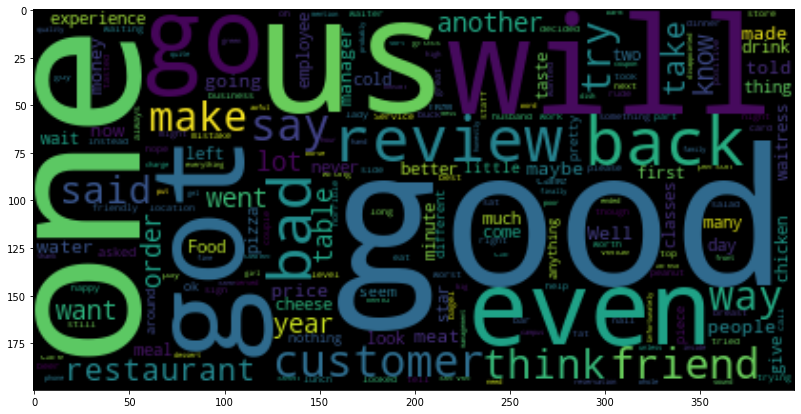

In [38]:
#@title Word cloud for differently rated reviews
num_stars = 1 #@param {type:"integer"}
this_star_text = ''
for t in yelp[yelp['stars'] == num_stars]['text'].values: # form field cell
    this_star_text += t + ' '
    for word in common_words:
      this_star_text = this_star_text.replace(word,'')
    
wordcloud = WordCloud()    
wordcloud.generate_from_text(this_star_text)
plt.figure(figsize=(14,7))
plt.imshow(wordcloud, interpolation='bilinear')

### (Optional Advanced Exercise) Training Logistic Regression with Word Vectors from Spacy

We can use the word vectors we introduced earlier to get more sophisticated representations of our Yelp reviews. First, we get the text data from our dataframe:

In [0]:
X_data = yelp['text']
y_data = yelp['is_good_review']

This helper function uses the Spacy `nlp` object to remove stop words, pronouns, and punctuation. It is identical to the `tokenize` function above, except it preserves the non-string attributes of the clean tokens (i.e. `token.vector`)

In [0]:
def tokenize_vecs(text):
    clean_tokens = []
    for token in nlp(text):
        if (not token.is_stop) & (token.lemma_ != '-PRON-') & (not token.is_punct): 
          # -PRON- is a special all inclusive "lemma" spaCy uses for any pronoun, we want to exclude these 
            clean_tokens.append(token)
    return clean_tokens

We want to represent each Yelp review with a vector. Since each review consists of multiple words, we want to find a way to create one vector for each review. 

Would adding the word vectors work? What about averaging? Which would be preferrable?

Implement your solution below: convert our array of reviews into an array of vector representations of those reviews.

In [0]:
X_word2vec = []
for text in X_data:
  review = tokenize_vecs(text) # returns cleaned list of spacy tokens
  #### YOUR CODE HERE
  r = 0
  for i in range(len(review)):
    r += review[i].vector
  r = r/len(review)
  X_word2vec.append(r)
  
  

  #### END CODE
  
X_word2vec = np.array(X_word2vec)

Now we follow the same procedure for training and testing the logistic regression that we used for the Bag of Words data.

In [0]:
# import a fresh logistic regression model from scikit-learn
logistic_model = LogisticRegression()

In [0]:
# train-test split
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(X_word2vec, y, test_size=0.2, random_state=101)

In [44]:
logistic_model.fit(X_train_word2vec, y_train_word2vec)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [45]:
#@title Run this to print the accuracy for our word2vec classifier


# Get our predictions.
preds = logistic_model.predict(X_test_word2vec)

# Get the confusion matrix.
cm = confusion_matrix(y_test_word2vec, preds)

# Get TP, FP, TN, and FN rates.
TP = cm[0][0]
TN = cm[1][1]
FP = cm[0][1]
FN = cm[1][0]

# Calculate and print accuracy.
accuracy = (TP + TN)/(TP + TN + FP + FN)
print ("The accuracy of the model is " + str(accuracy*100) + "%")

The accuracy of the model is 76.15384615384615%
